In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers as ppb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')

In [2]:
! nvidia-smi

Tue Jul 11 23:31:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8    21W / 170W |   1134MiB / 12288MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
df = pd.read_csv(
    'STT2.tsv',
    delimiter='\t',
    header=None
).rename(columns={0:"text", 1:"target"})
df.shape

(6920, 2)

In [4]:
df.head()

,text,target
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [33]:
tmp_df=df.copy()

In [34]:
true_df=df[df.target==1]
false_df=df[df.target==0].iloc[:500]

In [36]:
df=pd.concat([true_df, false_df])

In [6]:
df.target.value_counts()

target
1    3610
0    3310
Name: count, dtype: int64

# Baseline

In [5]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel,
    ppb.DistilBertTokenizer,
    'distilbert-base-uncased'
)

In [6]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
test=df.text.iloc[0]
test

'a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films'

In [8]:
tokenizer.encode_plus(test, add_special_tokens=True, truncation=True)

{'input_ids': [101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokenized_test=tokenizer(test, add_special_tokens=True)
tokenized_test

{'input_ids': [101, 1037, 18385, 1010, 6057, 1998, 2633, 18276, 2128, 16603, 1997, 5053, 1998, 1996, 6841, 1998, 5687, 5469, 3152, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
tokens=df.apply(lambda x: tokenizer(x.text, add_special_tokens=True), axis=1).tolist()

In [11]:
def get_max_len(tokens):
    key="input_ids"
    get_array=lambda x: x[key]
    max_len=0
    for value in tokens:
        cur_len=len(get_array(value))
        max_len=max(max_len, cur_len)
    return max_len

def padding(max_len, value):
    padded = value + [0]*(max_len-len(value))
    return padded

def make_padded_tokens(max_len, tokens):
    #input_ids, attention_mask = [], []
    result=[]
    for token in tokens:
        cur_id, cur_att = token["input_ids"], token["attention_mask"]
        result.append({"input_ids":padding(max_len,cur_id), "attention_mask":padding(max_len, cur_att)})
        #input_ids.append(padding(max_len, cur_id))
        #attention_mask.append(padding(max_len, cur_att))
    
    return result

In [12]:
df.target.value_counts()

target
1    3610
0    3310
Name: count, dtype: int64

In [13]:
max_len=get_max_len(tokens)

In [14]:
padded_tokens=make_padded_tokens(max_len, tokens)

In [15]:
for i in range(len(padded_tokens)):
    padded_tokens[i]["label"]=[df.target.iloc[i]]

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data=data
        self.len=len(data)
    def __getitem__(self, idx):
        item=self.data[idx]
        input_id, attention_mask, label = item["input_ids"], item["attention_mask"], item["label"]
        return np.array(input_id), np.array(attention_mask), label
    def __len__(self):
        return self.len
def create_dataloader(dataset, batch_size=32, shuffle=False):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [17]:
BATCH_SIZE=64

In [18]:
dataset=CustomDataset(padded_tokens)
dataloader=create_dataloader(dataset, batch_size=BATCH_SIZE)

In [19]:
next(iter(dataloader))

[tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
         [  101,  4593,  2128,  ...,     0,     0,     0],
         [  101,  2027,  3653,  ...,     0,     0,     0],
         ...,
         [  101,  1037, 19240,  ...,     0,     0,     0],
         [  101,  2009,  1005,  ...,     0,     0,     0],
         [  101,  1996,  6919,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 [tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
          0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
          1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])]]

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [21]:
model=model.to(device)

In [22]:
#Embeddings
embeddings = []
model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids, attention_mask, label = batch
        input_ids = input_ids.to(device)
        attention_mask=attention_mask.to(device)
        outputs=model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs)

In [23]:
prepared_embeddings=[]
for emb in embeddings:
    for x in emb["last_hidden_state"][:,0,:]:
        prepared_embeddings.append(x.cpu().numpy())

In [24]:
len(prepared_embeddings[0])

768

In [25]:
y=df.target.values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(prepared_embeddings, y, stratify=y)

In [27]:
lr=LogisticRegression().fit(X_train, y_train)
y_pred=lr.predict(X_test)
y_proba=lr.predict_proba(X_test)[:,1]

In [28]:
roc_auc_score(y_test, y_proba)

0.9153156699551186

In [29]:
accuracy_score(y_test, y_pred)

0.8317919075144509

In [30]:
confusion_matrix(y_test, y_pred)

array([[709, 119],
       [172, 730]])

In [31]:
y_train_proba=lr.predict_proba(X_train)[:,1]

In [32]:
np.mean(y_test)

0.5213872832369942

# Optuna 

## Model Class

In [213]:
class Classifier(torch.nn.Module):
    def __init__(self, n_epochs=10, 
                 lr=1e-5, dropout=.1, hidden_size=384, 
                 n_classes=2, device="cpu"):
        super().__init__()
        self.l1 = torch.nn.Linear(768, n_classes)
        self.silu = torch.nn.SiLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.device = device
        self.criteria = torch.nn.CrossEntropyLoss()
        self.epochs = n_epochs
        self.to(device)
    def forward(self, embeddings):
        outputs=self.l1(embeddings)
        return outputs
    
    def train_step(self, train):
        for batch in train:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            preds = self(X)
            loss=self.criteria(preds, y)
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
    
    def fit(self, train):
        self.train()
        for epoch in range(self.epochs):
            self.train_step(train)
    
    def predict(self, test):
        self.eval()
        with torch.no_grad():
            probas, labels = [], []
            softmax = torch.nn.Softmax(dim=-1)
            for X in test:
                X = torch.FloatTensor(X).to(self.device)
                score = self(X)
                proba = softmax(score)[1].item()
                probas.append(proba)
                label = torch.argmax(score).item()
                labels.append(label)
        return probas

In [214]:
nn = Classifier(lr=.003, n_epochs=18, dropout=.42, hidden_size=512, device=device)

## Dataloaders

In [56]:
class ClassifierDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    def __len__(self):
        return len(embeddings)

def create_dataloader(embeddings, labels=None, batch_size=1):
    if labels != None:
        dataset = ClassifierDataset(embeddings, labels)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    else

In [198]:
train = create_dataloader(X_train, y_train, batch_size=64)

In [215]:
nn.fit(train)

In [217]:
pred_p=nn.predict(X_test)
roc_auc_score(y_test, pred_p)

0.8618676157117302

In [113]:
def custom_softmax(array):
    return np.exp(array)/np.sum(np.exp(array))

In [167]:
custom_softmax([-0.1375,  0.0502])

array([0.45321229, 0.54678771])

In [218]:
"""
Optuna example that optimizes multi-layer perceptrons using PyTorch.

In this example, we optimize the validation accuracy of fashion product recognition using
PyTorch and FashionMNIST. We optimize the neural network architecture as well as the optimizer
configuration. As it is too time consuming to use the whole FashionMNIST dataset,
we here use a small subset of it.

"""

import os

import optuna
from optuna.trial import TrialState


def objective(trial):
    # Generate the model.
    device="cuda"

    # Generate the optimizers.
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    params={"lr" : trial.suggest_float("lr", 1e-5, 1e-1, log=True),
            "n_epochs" : trial.suggest_int("n_epochs", 5, 100),
            "dropout" : trial.suggest_float("dropout", 0., .5),
            "device" : device
           }
    
    model = Classifier(**params)
    model.fit(train)
    probas = model.predict(X_test)
    
    #accuracy = accuracy_score(y_test, probas)
    roc_score = roc_auc_score(y_test, probas)
    
    return roc_score

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-07-12 01:34:07,160] A new study created in memory with name: no-name-40b133c9-1f60-4f7c-a844-e4d5e5263ea0
[I 2023-07-12 01:34:07,487] Trial 0 finished with value: 0.8590390918731322 and parameters: {'lr': 0.07650490100651988, 'n_epochs': 51, 'dropout': 0.3533984877385376}. Best is trial 0 with value: 0.8590390918731322.
[I 2023-07-12 01:34:07,719] Trial 1 finished with value: 0.8618957335818418 and parameters: {'lr': 0.00404375318880164, 'n_epochs': 15, 'dropout': 0.23356977044441057}. Best is trial 1 with value: 0.8618957335818418.
[I 2023-07-12 01:34:07,967] Trial 2 finished with value: 0.8677670126503636 and parameters: {'lr': 0.013333008418528499, 'n_epochs': 25, 'dropout': 0.44357784810678186}. Best is trial 2 with value: 0.8677670126503636.
[I 2023-07-12 01:34:08,194] Trial 3 finished with value: 0.8433111603843311 and parameters: {'lr': 0.004042362587517483, 'n_epochs': 9, 'dropout': 0.3977980799599182}. Best is trial 2 with value: 0.8677670126503636.
[I 2023-07-12 01:34

[I 2023-07-12 01:34:18,065] Trial 38 finished with value: 0.8501163544244138 and parameters: {'lr': 0.004593679528619753, 'n_epochs': 11, 'dropout': 0.22369439728860607}. Best is trial 23 with value: 0.8690202662896195.
[I 2023-07-12 01:34:18,320] Trial 39 finished with value: 0.8570929335775572 and parameters: {'lr': 0.002111210734386336, 'n_epochs': 23, 'dropout': 0.3099994595892068}. Best is trial 23 with value: 0.8690202662896195.
[I 2023-07-12 01:34:18,587] Trial 40 finished with value: 0.8696730025600652 and parameters: {'lr': 0.004569165368533334, 'n_epochs': 28, 'dropout': 0.27072695587712137}. Best is trial 40 with value: 0.8696730025600652.
[I 2023-07-12 01:34:18,870] Trial 41 finished with value: 0.8702226399734354 and parameters: {'lr': 0.004511082702786542, 'n_epochs': 27, 'dropout': 0.277152468240702}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:19,152] Trial 42 finished with value: 0.8681325449618132 and parameters: {'lr': 0.004028965134050575, '

[I 2023-07-12 01:34:28,748] Trial 76 finished with value: 0.8666945167475391 and parameters: {'lr': 0.010475249641744167, 'n_epochs': 13, 'dropout': 0.17326686904355845}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:28,986] Trial 77 finished with value: 0.8608393050333666 and parameters: {'lr': 0.023759768067746496, 'n_epochs': 8, 'dropout': 0.24925856950165187}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:29,241] Trial 78 finished with value: 0.8687805949205738 and parameters: {'lr': 0.006605296309659923, 'n_epochs': 23, 'dropout': 0.23714231991701681}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:29,495] Trial 79 finished with value: 0.8663852201763125 and parameters: {'lr': 0.004824905289154087, 'n_epochs': 19, 'dropout': 0.2639042755588747}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:29,743] Trial 80 finished with value: 0.8663771864991379 and parameters: {'lr': 0.010396496442004206, 

[I 2023-07-12 01:34:38,998] Trial 114 finished with value: 0.8676920316633997 and parameters: {'lr': 0.0033777026158309607, 'n_epochs': 23, 'dropout': 0.2204013246023164}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:39,292] Trial 115 finished with value: 0.8656153261137354 and parameters: {'lr': 0.01122207165585638, 'n_epochs': 35, 'dropout': 0.26888132734075465}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:39,554] Trial 116 finished with value: 0.8683400816221601 and parameters: {'lr': 0.007770899427294707, 'n_epochs': 25, 'dropout': 0.25647421821864946}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:39,862] Trial 117 finished with value: 0.8636457362597343 and parameters: {'lr': 0.01581885104070469, 'n_epochs': 40, 'dropout': 0.23631642669226494}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:40,136] Trial 118 finished with value: 0.8686373276776246 and parameters: {'lr': 0.005327039603662

[I 2023-07-12 01:34:49,608] Trial 152 finished with value: 0.8683240142678107 and parameters: {'lr': 0.004249308733063089, 'n_epochs': 28, 'dropout': 0.26774011094744393}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:49,893] Trial 153 finished with value: 0.8689988431504867 and parameters: {'lr': 0.006191497450968537, 'n_epochs': 34, 'dropout': 0.30693164360421094}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:50,162] Trial 154 finished with value: 0.8677415726726437 and parameters: {'lr': 0.002619773107365041, 'n_epochs': 30, 'dropout': 0.2841796432237548}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:50,428] Trial 155 finished with value: 0.8690657904602761 and parameters: {'lr': 0.005243311467838011, 'n_epochs': 25, 'dropout': 0.23138596962457228}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:34:50,725] Trial 156 finished with value: 0.8664267275083818 and parameters: {'lr': 0.00199549602646

[I 2023-07-12 01:34:59,833] Trial 190 finished with value: 0.867983921934081 and parameters: {'lr': 0.004703653182091812, 'n_epochs': 23, 'dropout': 0.2023233054428649}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:35:00,089] Trial 191 finished with value: 0.868528873035766 and parameters: {'lr': 0.007084342494394497, 'n_epochs': 21, 'dropout': 0.19397385752730964}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:35:00,339] Trial 192 finished with value: 0.8692037019184421 and parameters: {'lr': 0.006600144021047678, 'n_epochs': 18, 'dropout': 0.20659773843177837}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:35:00,609] Trial 193 finished with value: 0.8687939843825316 and parameters: {'lr': 0.005457976267514659, 'n_epochs': 25, 'dropout': 0.1672205670157885}. Best is trial 41 with value: 0.8702226399734354.
[I 2023-07-12 01:35:00,872] Trial 194 finished with value: 0.8683896226314042 and parameters: {'lr': 0.00899214501074206

[I 2023-07-12 01:35:09,985] Trial 228 finished with value: 0.8693268849684546 and parameters: {'lr': 0.0036386279204871897, 'n_epochs': 28, 'dropout': 0.31708689698208103}. Best is trial 205 with value: 0.8705198860288997.
[I 2023-07-12 01:35:10,266] Trial 229 finished with value: 0.8694112385787889 and parameters: {'lr': 0.008982642900121017, 'n_epochs': 24, 'dropout': 0.18663445598053882}. Best is trial 205 with value: 0.8705198860288997.
[I 2023-07-12 01:35:10,551] Trial 230 finished with value: 0.8688408474993842 and parameters: {'lr': 0.010633056210968146, 'n_epochs': 25, 'dropout': 0.20174243887719878}. Best is trial 205 with value: 0.8705198860288997.
[I 2023-07-12 01:35:10,821] Trial 231 finished with value: 0.8694875585119488 and parameters: {'lr': 0.008998406157234198, 'n_epochs': 20, 'dropout': 0.20775648893270873}. Best is trial 205 with value: 0.8705198860288997.
[I 2023-07-12 01:35:11,093] Trial 232 finished with value: 0.8692264640037706 and parameters: {'lr': 0.00845647

[I 2023-07-12 01:35:20,409] Trial 266 finished with value: 0.8701074906005977 and parameters: {'lr': 0.006632368817975612, 'n_epochs': 32, 'dropout': 0.49695507088846214}. Best is trial 253 with value: 0.8709670940582923.
[I 2023-07-12 01:35:20,684] Trial 267 finished with value: 0.8581975641890807 and parameters: {'lr': 0.043490224282498886, 'n_epochs': 33, 'dropout': 0.46787681868292513}. Best is trial 253 with value: 0.8709670940582923.
[I 2023-07-12 01:35:20,945] Trial 268 finished with value: 0.8693563417847618 and parameters: {'lr': 0.006139573355181807, 'n_epochs': 26, 'dropout': 0.4254260744454237}. Best is trial 253 with value: 0.8709670940582923.
[I 2023-07-12 01:35:21,210] Trial 269 finished with value: 0.8532528358880427 and parameters: {'lr': 0.0009869479456750623, 'n_epochs': 29, 'dropout': 0.49574702901092804}. Best is trial 253 with value: 0.8709670940582923.
[I 2023-07-12 01:35:21,461] Trial 270 finished with value: 0.8599770236832803 and parameters: {'lr': 0.003138235

<Axes: ylabel='Count'>

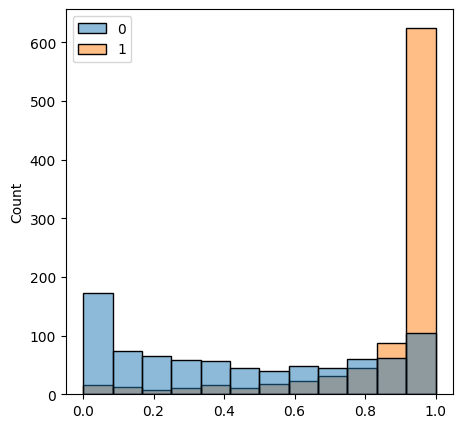

In [182]:
plt.figure(figsize=(5,5))
sns.histplot(x=pred_p, hue=y_test)

<Axes: ylabel='Count'>

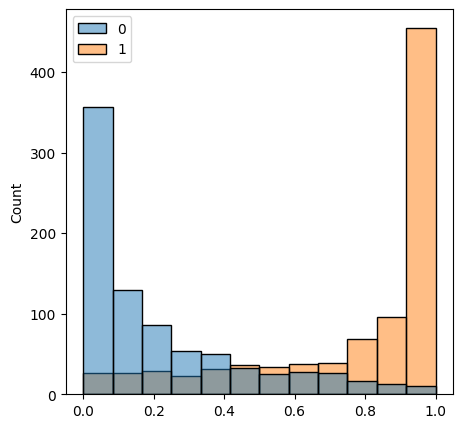

In [183]:
plt.figure(figsize=(5,5))
sns.histplot(x=y_proba, hue=y_test)

In [75]:
class CustomBertModel(torch.nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model=bert_model
        self.l1=torch.nn.Linear(768,324)
        self.l2=torch.nn.Linear(324, 1)
        self.relu=torch.nn.ReLU()
    def forward(self, input_ids, attention_mask=None):
        embeddings=self.bert_model(input_ids, attention_mask=attention_mask)
        outputs=self.l1(embeddings["last_hidden_state"][:,0,:])
        outputs=self.relu(outputs)
        outputs=self.l2(outputs)
        return outputs

In [64]:
mm=CustomBertModel(model)
mm.to(device)

CustomBertModel(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [76]:
opt=torch.optim.Adam(mm.parameters(), lr=1e-4)
criterion=torch.nn.BCELoss()

In [78]:
EPOCHS=3

In [80]:
next(iter(dataloader))

[tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
         [  101,  2023,  2003,  ...,     0,     0,     0],
         [  101,  5655,  6262,  ...,     0,     0,     0],
         ...,
         [  101,  2009,  2038,  ...,     0,     0,     0],
         [  101,  6320, 25624,  ...,     0,     0,     0],
         [  101,  2009,  1005,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]]

In [88]:
losses=[]
for epoch in range(EPOCHS):
    model.train()
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        print(input_ids)
        attention_mask=attention_mask.to(device)
        labels = torch.IntTensor(labels[0].reshape(64,1)).to(device)
        outputs=mm(input_ids, attention_mask=attention_mask)
        loss=criterion(outputs, labels)
        losses.append(loss.mean())
        opt.zero_grad()
        loss.backward()

tensor([[  101,  1037, 18385,  ...,     0,     0,     0],
        [  101,  2023,  2003,  ...,     0,     0,     0],
        [  101,  5655,  6262,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  2038,  ...,     0,     0,     0],
        [  101,  6320, 25624,  ...,     0,     0,     0],
        [  101,  2009,  1005,  ...,     0,     0,     0]], device='cuda:0')


TypeError: expected TensorOptions(dtype=int, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=long int, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [150]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [149]:
embeddings[0]t

'last_hidden_state'